In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

import src
from src.ml_utils import (
    fetch_daily_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHASEA_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_daily_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     31.555300     28.937300   
                          BTC     10532.400561  11094.361621  10385.558949   
                          ETH       221.191514    235.735515    220.461791   
                          XRP         0.319763      0.341772      0.319140   
2019-07-21 00:00:00+00:00 BNB        31.135900     31.551650     29.352900   
...                                        ...           ...           ...   
2022-01-19 00:00:00+00:00 ETH      3165.192686   3174.925601   3049.146630   
                          LINK       22.999903     23.146306     21.238588   
                          MATIC       2.125084      2.143135      2.014343   
                          SOL       141.580646    142.663900    132.938345   
                          XRP         0.752174      0.752978      0.724094   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        31.135900 2019-07-21 00:30:00+00:00   
                          BTC     10758.259167 2019-07-21 00:30:00+00:00   
                          ETH       229.000753 2019-07-21 00:30:00+00:00   
                          XRP         0.333653 2019-07-21 00:30:00+00:00   
2019-07-21 00:00:00+00:00 BNB        30.417250 2019-07-22 00:30:00+00:00   
...                                        ...                       ...   
2022-01-19 00:00:00+00:00 ETH      3083.714833 2022-01-20 00:30:00+00:00   
                          LINK       21.551247 2022-01-20 00:30:00+00:00   
                          MATIC       2.029769 2022-01-20 00:30:00+00:00   
                          SOL       135.258810 2022-01-20 00:30:00+00:00   
                          XRP         0.738638 2022-01-20 00:30:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB    -0.036594  
                          BTC    -0.019768  
                          ETH    -0.018317  
                          XRP    -0.015445  
2019-07-21 00:00:00+00:00 BNB    -0.001055  
...                                    ...  
2022-01-19 00:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[7988 rows x 6 columns]

In [2]:
class ExampleModel:
    def __init__(self):
        self._model = Ridge()
    
    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        return self._model.fit(df[features], df['ret'])
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()

        df['feature_1'] = (df['cl'] / df.groupby('symbol')['cl'].shift(1) - 1).fillna(0)
        df['feature_2'] = (df['cl'] / df.groupby('symbol')['cl'].shift(2) - 1).fillna(0)
        df['feature_3'] = (df['cl'] / df.groupby('symbol')['cl'].shift(3) - 1).fillna(0)
        df['feature_4'] = (df['cl'] / df.groupby('symbol')['cl'].shift(4) - 1).fillna(0)

        return df

return with cost statistics
mean 0.004166369817401049
std 0.04740166001513675
sharpe 0.0878950192054583
max drawdown 0.5467654897418774


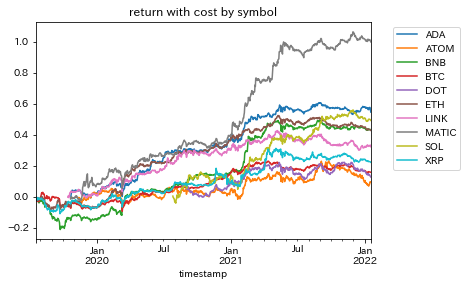

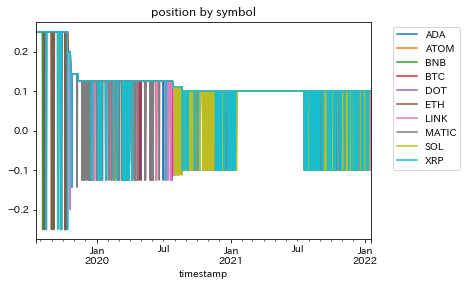

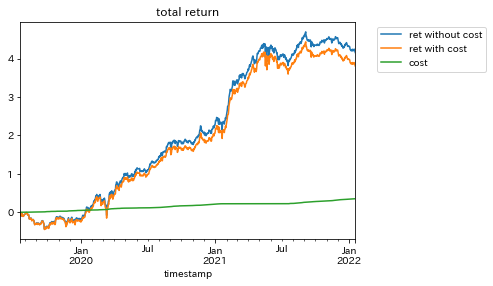

In [3]:
df = pd.read_pickle('/tmp/df.pkl')
df = df.dropna()

model = ExampleModel()

# cv
calc_position_cv(model, df)
visualize_result(df)

# save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model.xz', 'wb') as f:
    f.write(data)

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
print(model.predict(df))

timestamp                  symbol
2019-07-20 00:00:00+00:00  BNB       0.25
                           BTC       0.25
                           ETH       0.25
                           XRP       0.25
2019-07-21 00:00:00+00:00  BNB       0.25
                                     ... 
2022-01-19 00:00:00+00:00  ETH       0.10
                           LINK      0.10
                           MATIC     0.10
                           SOL       0.10
                           XRP       0.10
Name: position, Length: 7988, dtype: float64
